In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime as dt
import random

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
#fetch original mnist dataset
from sklearn.datasets import fetch_openml

# import custom module
from mnist_helpers import *
from mnist_helpers import *


# it creates mldata folder in your root project folder
mnist = fetch_openml('mnist_784')

/Users/wenging/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:996: UserWarning: Illegal line #1
	"$ cat ~/.matplotlib/matplotlibrc
"
	in file "/Users/wenging/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)


In [2]:
#solver info

def H(X, y, theta):
    y = y.reshape(y.shape[0], 1) # change to 2d array
    return (1 - y * (X@theta))

def svm_loss_re(X, y, theta, lamda):
    h = H(X, y, theta)
    penalty = lamda*(theta.T @ theta)
    loss = np.mean([max(0, i) for i in h])
    return np.asscalar(penalty) + np.asscalar(loss) 

def svm_grad_re(X, y, theta, lamda):
    h = H(X, y, theta)
    y = y.reshape(y.shape[0], 1) # change to 2d array
    cond = np.array([(i > 0)*1 for i in h])
    return 2*lamda*theta - X.T @ (y*cond)/y.shape[0]


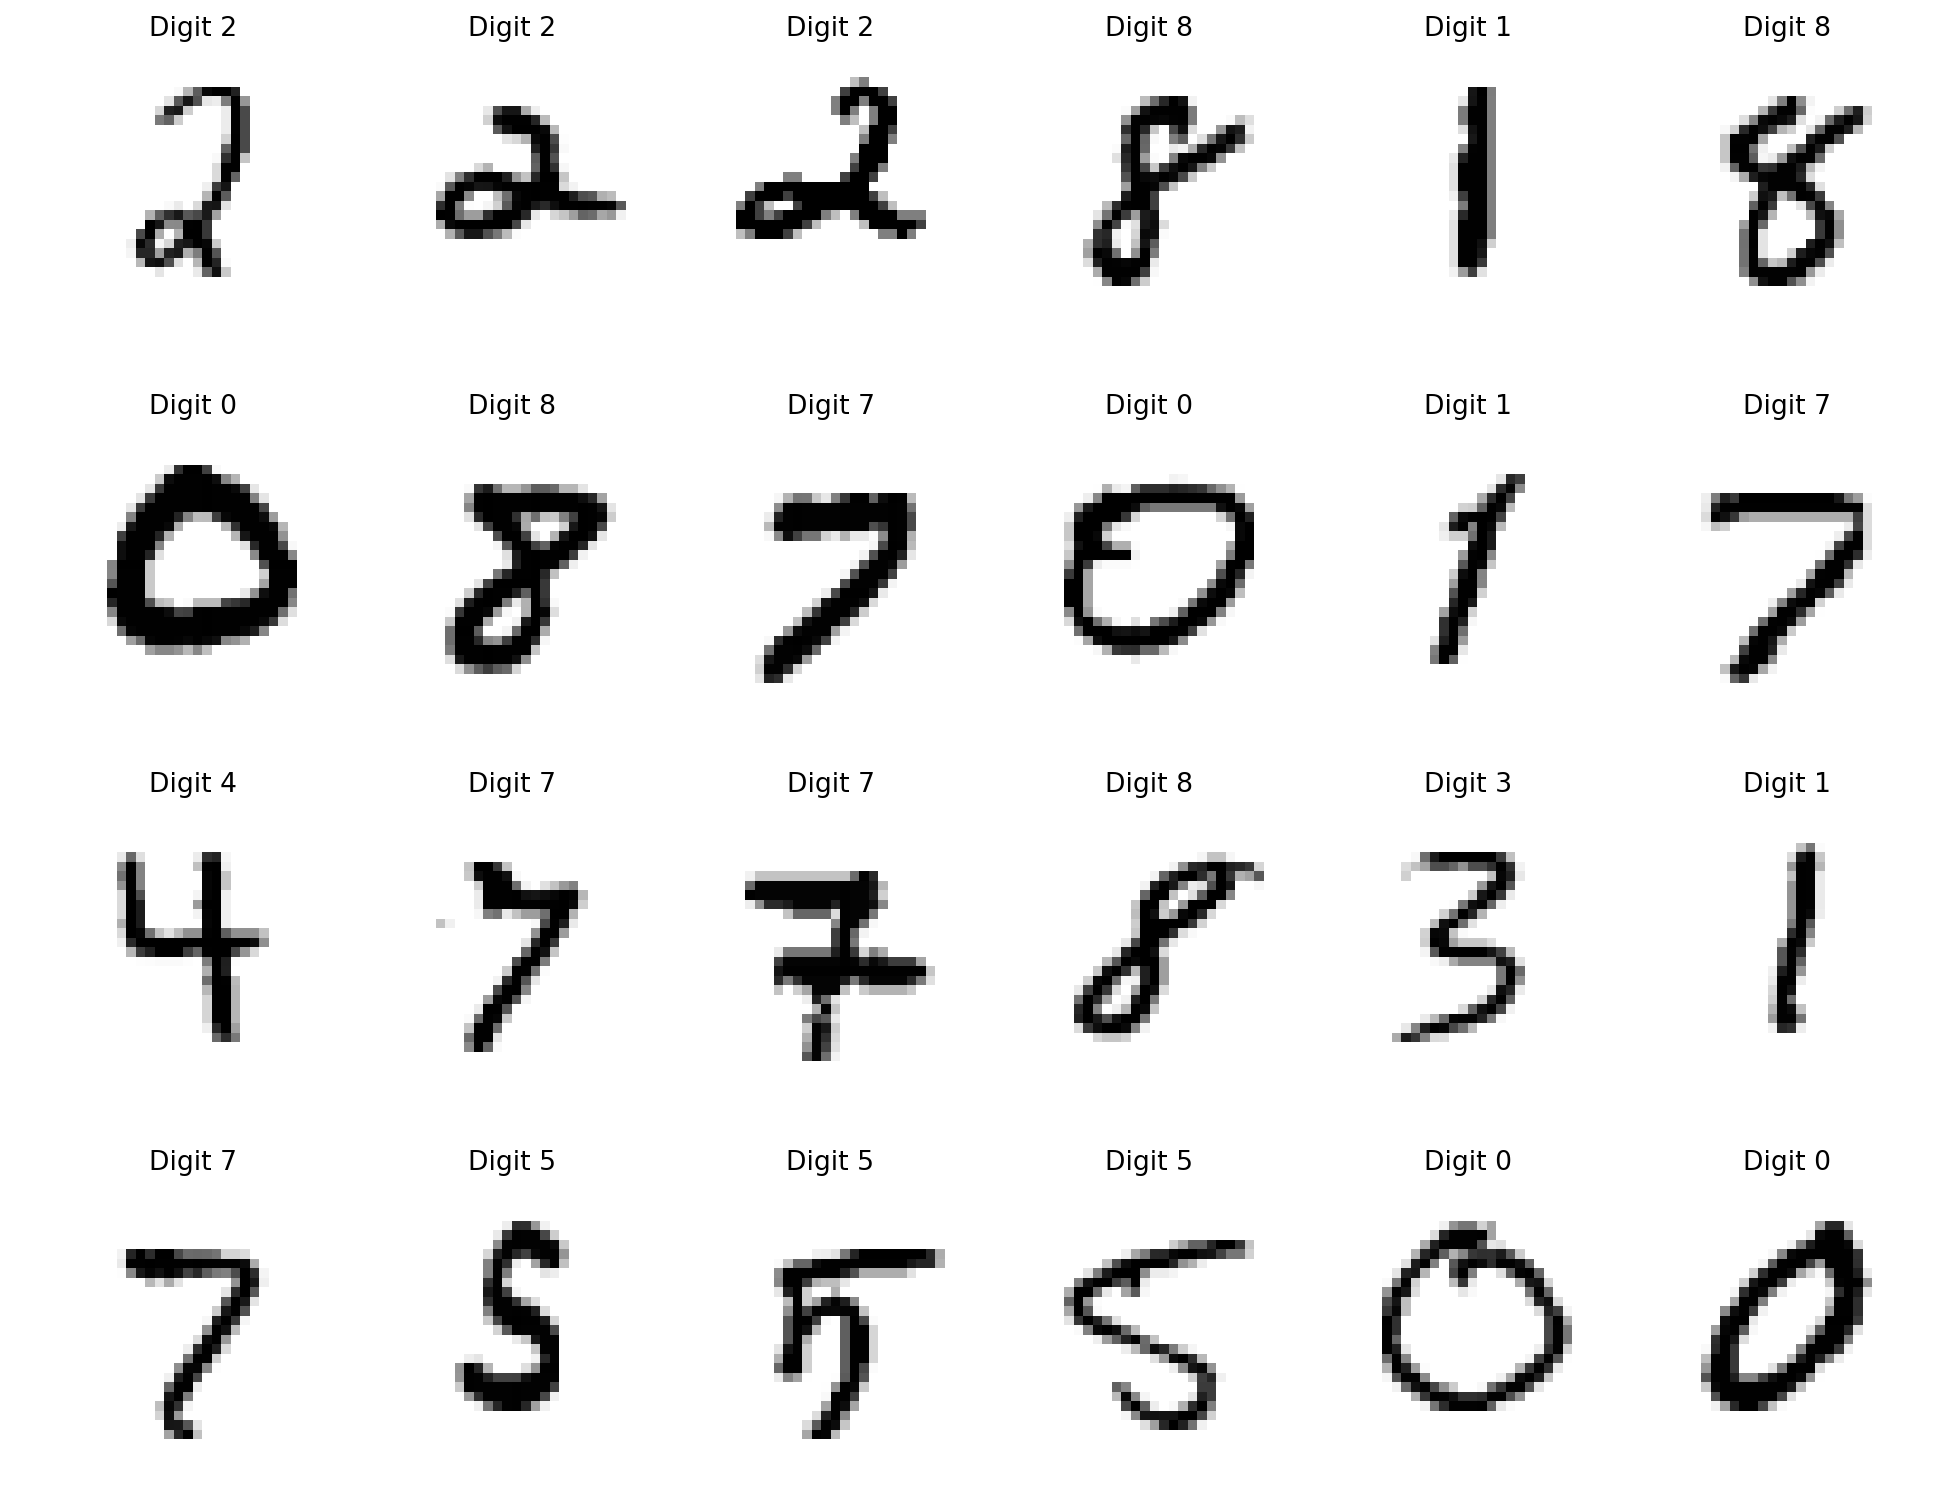

In [3]:
#minist object contains: data, COL_NAMES, DESCR, target fields
#you can check it by running
mnist.keys()

#data field is 70k x 784 array, each row represents pixels from 28x28=784 image
images = mnist.data
targets = mnist.target

# Let's have a look at the random 16 images, 
# We have to reshape each data row, from flat array of 784 int to 28x28 2D array

#pick  random indexes from 0 to size of our dataset
show_some_digits(images,targets)

In [4]:
#---------------- classification begins -----------------
#scale data for [0,255] -> [0,1]
#sample smaller size for testing
#rand_idx = np.random.choice(images.shape[0],10000)
#X_data =images[rand_idx]/255.0
#Y      = targets[rand_idx]

#full dataset classification
X_data = images/255.0
Y = targets

In [6]:
# Change the problem to binary classification: if the hand-written figure is 0
y = []
for i in Y:
    if i == '0':
        y.append(1)
    else:
        y.append(-1)
y = np.array(y)

print(X_data.shape)
print(y.shape)

(70000, 784)
(70000,)


In [13]:
# lamda: penalty
# alpha: learning rate
# var: noise variance
# pLevel: noise adding probability
# num_iter: number of iterations
def train(X_data, y, num_worker_left, num_worker_right, num_iter, var, pLevel, lamda, alpha, lr_fade):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    
    w_init = np.random.rand(X_data.shape[1], 1)
    weight, weight_left, weight_right = w_init, w_init, w_init
    
    total_loss_list = []
    
    num_data = len(y)
    num_worker = num_worker_left + num_worker_right
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
       
    for i_iter in range(num_iter):
        #left topo
        gradient_list_left, gradient_list_right = [], []
        for j_worker in range(num_worker_left):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from left topo worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro>=pLevel)
            gradient_list_left.append(grad)
        #updata weight with average grad for left branch workers
        alpha *= lr_fade
        weight_left -= alpha * 1./num_worker*sum(gradient_list_left)
        
        #right topo
        for j_worker in range(num_worker_left, num_worker):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from right topo worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro>=pLevel)
            gradient_list_right.append(grad)
        #updata weight with average grad for left branch workers
        alpha *= lr_fade
        weight_right -= alpha * 1./num_worker*sum(gradient_list_left)
        
        #upodate weight based on weight_left and weight_right
        weight = 1/2*(weight_left + weight_right)
        
        total_loss_list.append(svm_loss_re(X_data, y, weight,lamda))
        
    return total_loss_list

    

In [19]:
# default iterations: 100
def tuningNoise(var, pLevel):
    return train(X_data, y, num_worker_left=5, num_worker_right=5,num_iter=100, var=var, pLevel=pLevel, lamda=0.03, alpha=0.2, lr_fade=1)
    

## Tuning Noise Var

In [39]:
Loss_var = []
varList = [0, 0.02, 0.1, 0.5, 1, 10]
for i in varList:
    Loss_var.append(tuningNoise(var=i, pLevel=0.5))

In [41]:
len(varList)

6

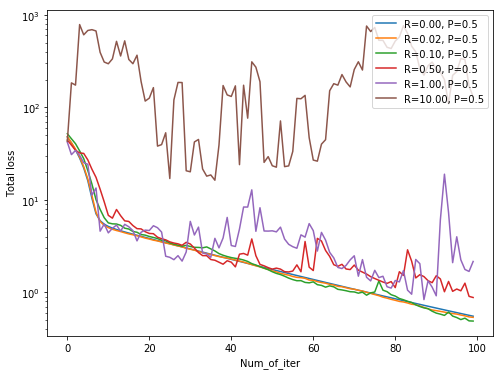

In [62]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import matplotlib.pyplot as plt

x_axis = np.arange(0, 100)
for i in range(len(Loss_var)):
    plt.semilogy(x_axis, Loss_var[i], label='R=%.2f, P=0.5' % (varList[i]))
    
plt.xlabel('Num_of_iter')
plt.ylabel('Total loss')
plt.legend(loc='upper right', prop={'size': 10})
plt.savefig('2star_R.png')
plt.show()

## Tuning Noise P

In [54]:
Loss_p = []
pList = [0, 0.02, 0.1, 0.5, 1]
for i in pList:
    Loss_p.append(tuningNoise(var=0.1, pLevel=i))

In [57]:
len(Loss_p[0])

100

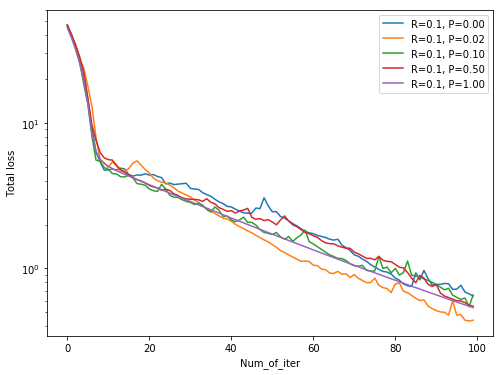

In [61]:
x_axis = np.arange(0, 100)
for i in range(len(Loss_p)):
    plt.semilogy(x_axis, Loss_p[i], label='R=0.1, P=%.2f' % (pList[i]))
    
plt.xlabel('Num_of_iter')
plt.ylabel('Total loss')
plt.legend(loc='upper right', prop={'size': 10})
plt.savefig('2star_p.png')
plt.show()